# Australian Sedimentary Thickness

This notebook gives the final estimate of sedimentary thickness at all seismic stations across Australia.
For those stations where a thickness estimate was not possible from borehole data, it is predicted using the empirical relationship determined from other stations.

In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgb
import seaborn as sns
import numpy as np
from numpy.polynomial import Polynomial
from scipy import stats
from scipy import optimize
import os
import geopandas as gpd
import pygmt

from utils import get_australian_sedimentary_basins, get_geological_timeline, australia_basemap

Load the seismic measurements and sediment thicknesses estimated from boreholes

In [2]:
dataroot = os.path.join("..", "data", "processed")
run = max(
    [
        os.path.join(dataroot, d)
        for d in os.listdir(dataroot)
        if os.path.isdir(os.path.join(dataroot, d))
    ],
    key=os.path.getmtime,
)
seismics = gpd.read_file(os.path.join(run, "dataframe.json"))

In [17]:
empirical = Polynomial([382.62, -545.52, 1369.64])

In [18]:
lons = np.array([s.geometry.x for _, s in seismics.iterrows()])
lats = np.array([s.geometry.y for _, s in seismics.iterrows()])
delays = np.array([s.delays for _, s in seismics.iterrows()])
sed_thick = np.array([s.MAX_DEPTH for _, s in seismics.iterrows()])

idx = ~np.isnan(sed_thick)  # where a depth was estimated from boreholes
sed_thick[~idx] = empirical(delays[~idx])

plot [WARNING]: Your data array row 44 contains NaNs - no resampling taken place!


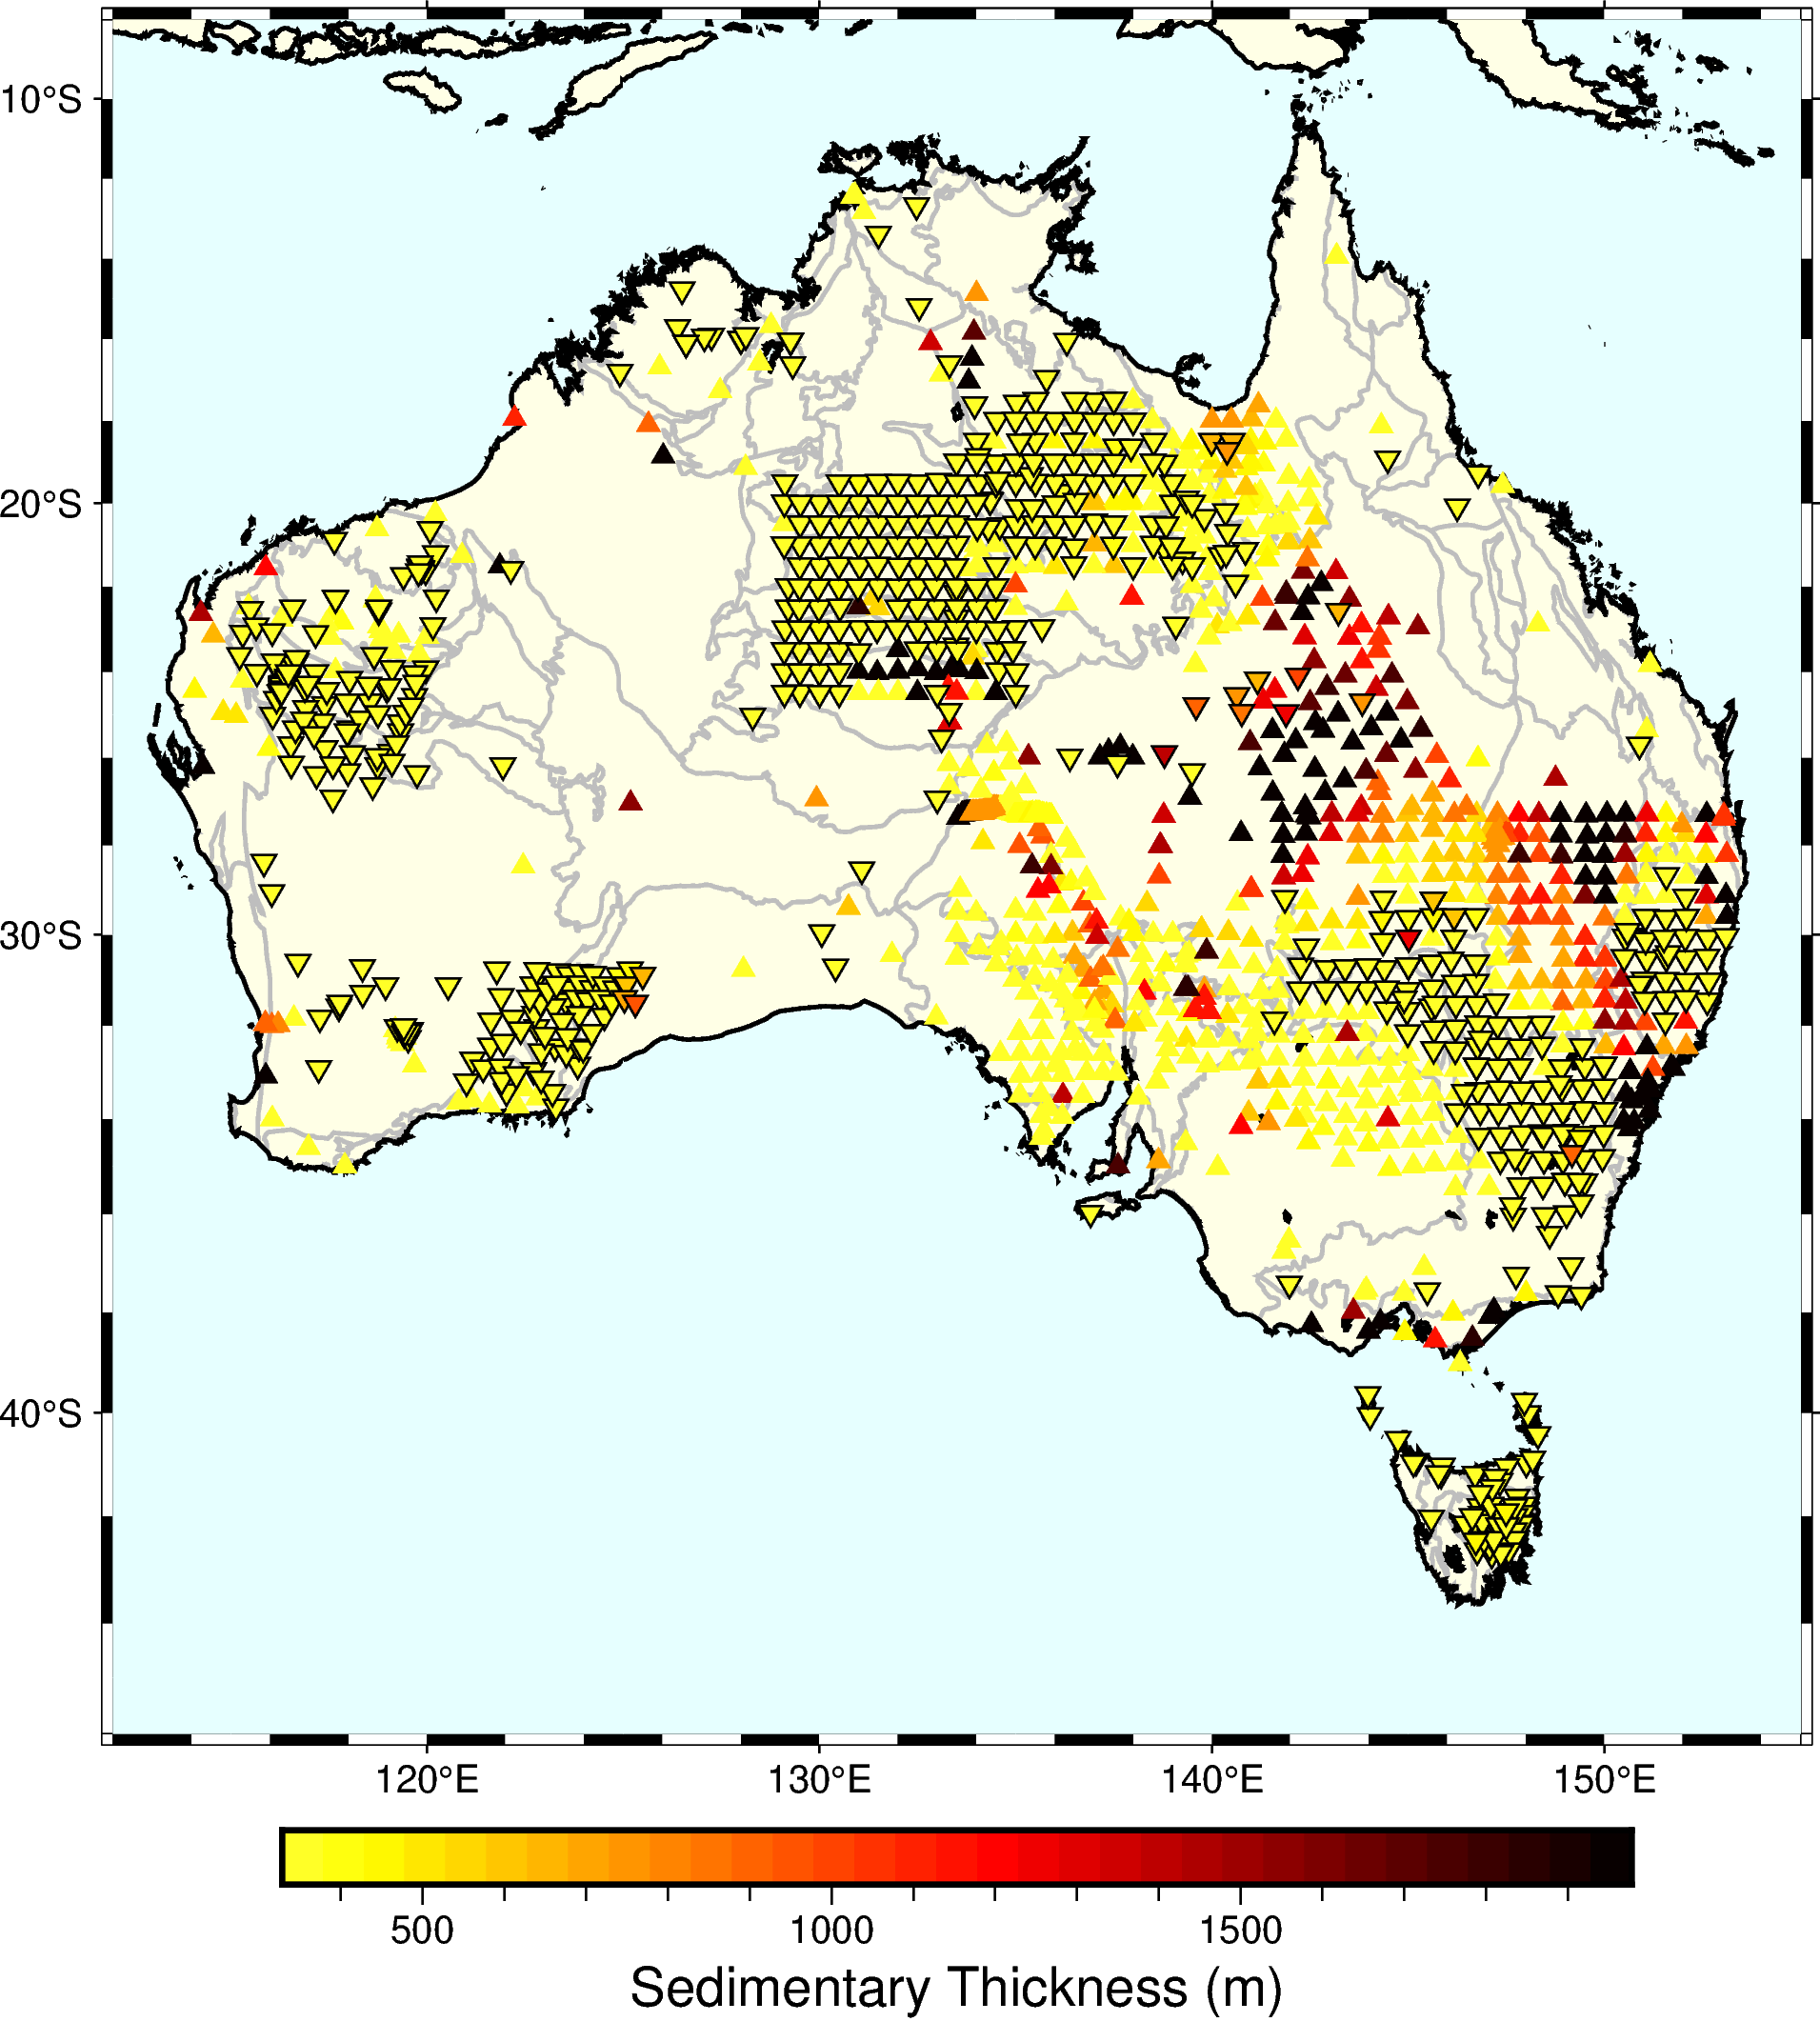

In [19]:
fig, region, projection = australia_basemap()
pygmt.makecpt(
    cmap="hot",
    series=[sed_thick[~idx].min(), 2000, 50],
    truncate=[0, 0.8],
    background="o",
    reverse=True,
)
fig.plot( # estimated from boreholes
    region=region,
    projection=projection,
    x=lons[idx],
    y=lats[idx],
    style=f"tc",
    fill=sed_thick[idx],
    cmap=True,
    size=np.full_like(lons[idx], 0.25),
)
fig.plot( # estimated from empirical relation
    region=region,
    projection=projection,
    x=lons[~idx],
    y=lats[~idx],
    style=f"ic",
    fill=sed_thick[~idx],
    pen="0.5p,black",
    cmap=True,
    size=np.full_like(lons[~idx], 0.25),
)
fig.colorbar(
    region=region, projection=projection, frame=["af+lSedimentary Thickness (m)"]
)
fig.show()

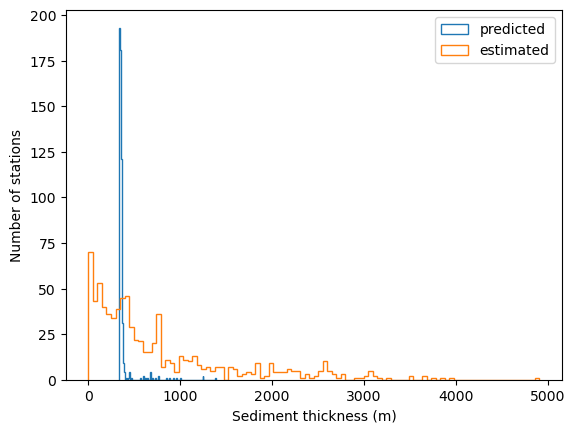

In [20]:
plt.hist(sed_thick[~idx],bins=100, histtype="step", label="predicted")
plt.hist(sed_thick[idx], bins=100, histtype="step", label="estimated")
plt.xlabel("Sediment thickness (m)")
plt.ylabel("Number of stations")
plt.legend()

Text(0.19914722116760605, 328.3006039543238, '(0.20, 328.30)')

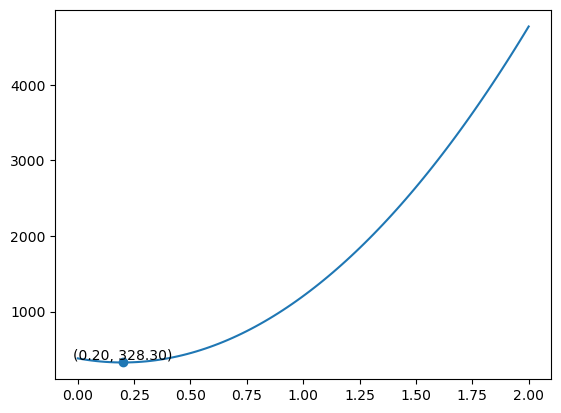

In [38]:
t, d = empirical.linspace(domain=[0,2])
_mint = empirical.deriv().roots()[0]
_mind = empirical(_mint)
plt.plot(t, d)
plt.scatter(_mint, _mind)
plt.text(_mint, _mind, f"({_mint:.2f}, {_mind:.2f})", ha="center", va="bottom")